<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/shine-on-you/HomeWork2_Regression%26Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа 2

## Регрессия

С 1-ого октября отменяется НДС на бриллианты, теперь они становятся новым инвестиционным инструментом. Давайте сделаем модель ценообразования для них.

Скачайте датасет diamonds.csv

В нем представлены характеристики бриллиантов и их цены с сайта jamesallen (B2C площадка) с 2022-07-01

**Описание полей**


* fluor - флуорисценция (свойство камня светиться в ультрафиолетовых лучах)
* symmetry - показатель симметричности
* platform - название платформы, где был размещен камень
* quality_group - составной показатель из cut polish symmetry
* size_group - каратно весовая группа
* big_size_group - каратно-весовая группа
* shape - форма
* color - цвет
* clarity - чистота
* cut - качество огранки (может быть только у круглых камней)
* polish - полировка
* id - номер камня
* date - дата
* price - цена
* carat - кол-во карат
* tablepercent - размер площадки по отношению ширине
* price_per_carat - цена за карат
* z - длина (diameter)
* x - ширина
* depth_perc - отношение высоты к ширине
* y - высота



In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = 'drive/MyDrive/'

Mounted at /content/drive


In [176]:
df = pd.read_csv('https://raw.githubusercontent.com/Dimildizio/DS_course/main/shine-on-you/diamonds.csv', index_col=0)
df.shape

(222222, 17)

## EDA

In [ ]:
df.head(10)

,fluor,symmetry,platform,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
135269,NaN,EX,jamesallen,PS,F,SI1,NaN,EX,13870838,202206,12850.0,1.55,8290.32,10.29,6.41,62.0,3.97420
48477,MED,EX,jamesallen,RD,H,VVS2,EX,EX,11725253,202207,7510.0,1.02,7362.75,6.41,6.45,62.5,4.03125
236786,NaN,EX,jamesallen,EM,H,IF,NaN,EX,14444347,202205,21220.0,2.01,10557.21,8.60,6.37,65.0,4.14050
235781,NaN,EX,jamesallen,RD,E,VS2,EX,EX,14438434,202207,8660.0,1.00,8660.00,6.39,6.44,61.4,3.95416
277744,NaN,VG,jamesallen,RD,F,VS1,VG,EX,14615276,202206,8480.0,1.00,8480.00,6.28,6.36,62.3,3.96228


In [304]:
#print('number of duplicates:',df.duplicated(keep=False).sum() - df.shape[0])
#Удалим пусте значения (у них айди 0)
df1=df.copy()
df1=df1.drop(df1[df1.id == 0].index)
#поскольку у нас только одна платформа, нам этот параметр не нужен
df1=df1.drop('platform', axis = 1)
#заменим пустые значения в fluor. в других колонках пока не будет - cut уже есть, а симметрия No
df1['fluor'] = df1['fluor'].replace('NONE', np.nan)
#Удалим полные дубли
df1 = df1.drop_duplicates()

In [305]:
#Для ускорения манипуляций с датасетом переведем все в более "легкие" типы данных
for col in ['fluor', 'symmetry','shape', 'clarity', 'color', 'cut','polish']:
  df1[col] = df1[col].astype('category')
for col in ['id','date']:
  df1[col] = df1[col].astype('int32')
for col in ['price', 'carat','price_per_carat', 'z', 'x', 'y', 'depth_perc']:
  df1[col] = df1[col].astype('float32')

In [307]:
df1.describe().apply(lambda x: round(x,2))

,id,date,price,carat,price_per_carat,z,x,depth_perc,y
count,219677.00,219677.00,219677.00,219677.00,219677.00,219677.00,219677.00,219677.00,219677.00
mean,13588521.46,202206.03,11520.33,1.34,7005.84,7.07,6.42,64.08,4.10
std,2543922.34,0.82,24338.61,0.71,5126.78,1.36,1.04,4.19,0.59
min,19423.00,202205.00,920.00,0.81,1029.70,4.52,3.87,46.00,2.47
25%,13598656.00,202205.00,4210.00,1.00,4147.06,6.26,5.68,61.80,3.81
50%,14400004.00,202206.00,6560.00,1.01,5850.00,6.53,6.38,63.00,4.00
75%,14834289.00,202207.00,11550.00,1.50,8592.59,7.65,6.82,66.00,4.32
max,15418506.00,202207.00,2380380.00,21.17,955000.00,21.88,18.05,78.00,10.74


In [308]:
#Сколько уникальных значений в столбцах
for c in df1.columns:
  print(f'{c}: {df1[c].nunique()}')

fluor: 3
symmetry: 4
shape: 10
color: 10
clarity: 9
cut: 3
polish: 3
id: 162277
date: 3
price: 8436
carat: 631
price_per_carat: 52604
z: 1115
x: 903
depth_perc: 317
y: 37649


Необходимо предсказать `price_per_carat`

### Задание 1: Очистка

Не все камни успевают продаться за один месяц, поэтому в таблице есть повторы. Объедините данные по одному камню: подумайте, как лучше это сделать, какую цену брать.

**Попробуйте найти аномалии:** вдруг цена на некоторые камни сильно меняется (то есть продавец сам не знает, по какой цене их продавать). Также убедитесь, что остальные параметры камня не меняются.

In [318]:
# разделите выборку на две части
id_stat = df1.groupby(by='id')['id'].count().to_frame().rename({'id':'occurrence'},axis=1) #Посчитайте статистику по кол-ву камней

one = id_stat[id_stat['occurrence'].isin([1])].index       # те камни, которые встречались один раз
three = id_stat[id_stat['occurrence'].isin([2,3])].index   # те камни, которые встречались 2 или 3 раза

In [319]:
num_more_than_three = df1.shape[0] - (df1[df1['id'].isin(one)].shape[0] + df1[df1['id'].isin(three)].shape[0])

,occurrence
id,


In [321]:
df_one = df1[df1['id'].isin(one)]
df_three = df1[df1['id'].isin(three)]

df_three

,fluor,symmetry,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
135269,NaN,EX,PS,F,SI1,NaN,EX,13870838,202206,12850.0,1.55,8290.320312,10.29,6.41,62.000000,3.97420
48477,MED,EX,RD,H,VVS2,EX,EX,11725253,202207,7510.0,1.02,7362.750000,6.41,6.45,62.500000,4.03125
236786,NaN,EX,EM,H,IF,NaN,EX,14444347,202205,21220.0,2.01,10557.209961,8.60,6.37,65.000000,4.14050
235781,NaN,EX,RD,E,VS2,EX,EX,14438434,202207,8660.0,1.00,8660.000000,6.39,6.44,61.400002,3.95416
277744,NaN,VG,RD,F,VS1,VG,EX,14615276,202206,8480.0,1.00,8480.000000,6.28,6.36,62.299999,3.96228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229133,NaN,EX,RD,I,SI2,EX,EX,14409793,202205,3330.0,0.90,3700.000000,6.13,6.18,62.000000,3.83160
268649,FNT,VG,RD,K,VS1,VG,EX,14581367,202205,3840.0,1.01,3801.979980,6.27,6.33,63.000000,3.98790
20595,NaN,EX,RD,D,VS2,EX,EX,7535786,202207,8700.0,0.97,8969.070312,6.36,6.32,62.200001,3.93104
282754,NaN,EX,RD,D,VS2,EX,EX,14631732,202206,6650.0,0.90,7388.890137,6.13,6.18,61.700001,3.81306


In [363]:
stat = df_three.groupby('id')['price', 'carat', 'price_per_carat','depth_perc', 'x','y','z'].agg(np.std)
stat.sort_values(by='depth_perc', ascending = False)
#stat[stat['depth_perc'] < 0.5]

<ipython-input-363-3915861bee5a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stat = df_three.groupby('id')['price', 'carat', 'price_per_carat','depth_perc', 'x','y','z'].agg(np.std)


,price,carat,price_per_carat,depth_perc,x,y,z
id,,,,,,,
14408689,106.066017,0.070711,582.182281,1.909189,0.056568,0.154128,0.035355
14020956,236.713610,0.034641,525.141101,1.039230,0.005774,0.069213,0.005774
14104780,777.817459,0.021213,487.599844,0.848529,0.028284,0.057502,0.028284
14579436,0.000000,0.000000,0.000000,0.707107,0.035355,0.072973,0.056568
8336692,0.000000,0.000000,0.000000,0.636397,0.000000,0.033093,0.000000
...,...,...,...,...,...,...,...
14494938,42.426407,0.000000,47.142754,0.000000,0.000000,0.000000,0.000000
13690599,120.208153,0.000000,119.020434,0.000000,0.000000,0.000000,0.000000
13690607,268.700577,0.000000,177.943352,0.000000,0.000000,0.000000,0.000000


In [323]:
for x in ['price', 'carat', 'price_per_carat', 'depth_perc', 'x','y','z']:
  print(f'std not null in {x}: {stat[stat[x] > 0].shape[0]}')

std not null in price: 43047
std not null in carat: 11
std not null in price_per_carat: 43051
std not null in depth_perc: 30587
std not null in x: 82
std not null in y: 30601
std not null in z: 84


In [359]:
df_three_2 = df_three.copy()
#странно что размер каменя изменился. Возможно другие измерения.поскольку x,y,z тоже изменяются
carat_to_drop = stat[stat['carat'] > 0]
df_three_2 = df_three_2[~df_three_2['id'].isin(carat_to_drop.index)]
#изменение в %_глубине тоже странное, сочтем выбросом все что выше 0.6 стд
depth_to_drop = stat[stat['depth_perc'] > 0.6]
df_three_2 = df_three_2[~df_three_2['id'].isin(depth_to_drop.index)]
#сколько % датасета мы убрали
round(1-df_three_2.sort_values(by='id').shape[0] / df_three.shape[0],2)

0.05

price
count    2.196770e+05
mean     1.152033e+04
std      2.433861e+04
min      9.200000e+02
25%      4.210000e+03
50%      6.560000e+03
75%      1.155000e+04
max      2.380380e+06
Name: price, dtype: float64


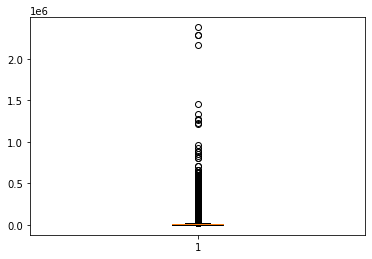

carat
count    219677.000000
mean          1.337380
std           0.706608
min           0.810000
25%           1.000000
50%           1.010000
75%           1.500000
max          21.170000
Name: carat, dtype: float64


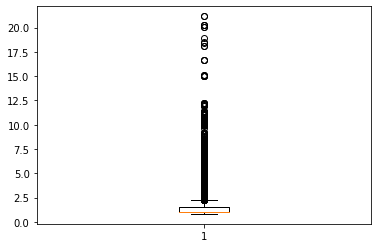

price_per_carat
count    219677.000000
mean       7005.844238
std        5126.775391
min        1029.699951
25%        4147.060059
50%        5850.000000
75%        8592.589844
max      955000.000000
Name: price_per_carat, dtype: float64


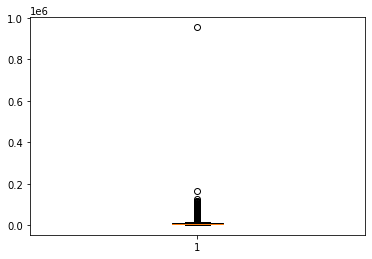

depth_perc
count    219677.000000
mean         64.084625
std           4.190434
min          46.000000
25%          61.799999
50%          63.000000
75%          66.000000
max          78.000000
Name: depth_perc, dtype: float64


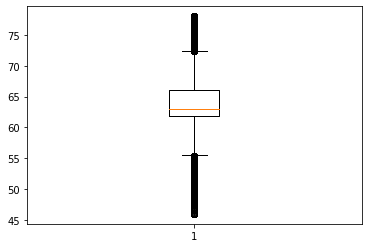

x
count    219677.000000
mean          6.419926
std           1.037386
min           3.870000
25%           5.680000
50%           6.380000
75%           6.820000
max          18.049999
Name: x, dtype: float64


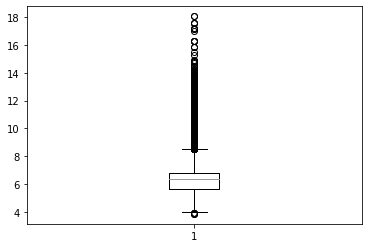

y
count    219677.000000
mean          4.095063
std           0.593353
min           2.472100
25%           3.811500
50%           3.997300
75%           4.319820
max          10.739750
Name: y, dtype: float64


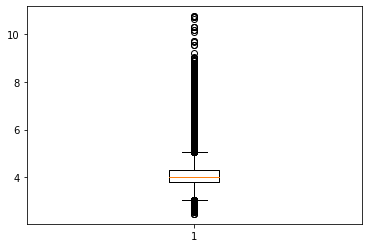

z
count    219677.000000
mean          7.074827
std           1.359820
min           4.520000
25%           6.260000
50%           6.530000
75%           7.650000
max          21.879999
Name: z, dtype: float64


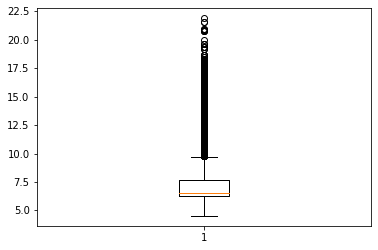

In [399]:
#check on df_three_2, df_one and df1. then cut iqr
for x in ['price', 'carat', 'price_per_carat', 'depth_perc', 'x','y','z']:
  print(x)
  print(df1[x].describe())
  plt.boxplot(df1[x])
  plt.show()


In [ ]:
#take the altest date

In [401]:
#TODO: do it for df_three_2, df_one after 
#Соберем датасет, с обрезанием выбросов по iqr*1.5
def iqr_cut(mydf, cols):
  df_to_cut = mydf.copy()
  for col in cols:
    desc = df_to_cut[col].describe()
    irq = desc['mean'] + (desc['75%']-desc['25%']) *1.5
    df_to_cut = df_to_cut[df_to_cut[col] <= irq]
  return df_to_cut

iqr_cut(df1, ['price','carat','price_per_carat']).shape

(175585, 16)

In [ ]:

#df_one = df.query('...') 
#df_three = df.query('...') 


 # Посчитайте дстандартное отклонение по нескольким полям,
#  подумайте где оно должно равняться 0, а где меняться в каких-то разумных пределах

# Удалите аномальные наблюдения
df_three = df_three.query('...').sort_values(by=['id','date'])

df_three = df_three.groupby('...').agg('l...').reset_index() #тепреь в качестве цены возьмем последнее значение по времени

df = pd.concat([df_one, df_three]).reset_index(drop=True) # соединяем результаты

Цены на бриллианты достаточно сильно меняются, попробуйте вычислить коэффициент инфляции и привести цены к последнему месяцу. Стоит учесть, что цены на все бриллианты не изменяются синхронно, то есть изменение в определенных группах может быть разным.

*Определите эти группы и рассчитайте коэффициенты инфляции для каждой из них. Подправьте цены на эти коэффициенты и создайте новую переменную.*

In [ ]:
categories = ['...'] #определите по каким группам отпределять инфляцию (к примеру можно добавить каратную группу)

df_index = df.groupby(['date'] + categories)[['price_per_carat']]\
             .mean()\
             .reset_index() # индекс цен

date_max = df_index.date.max()


df_index = df_index.merge(df_index.query('date == @date_max')[categories + ['price_per_carat']]\
                          .rename(columns={'price_per_carat': 'price_per_carat_max'}), 
                          on=categories, how='outer') # сопоставляем группы с максимальной датой

df_index['inflation'] = df_index.['...'] / df_index.price_per_carat # вычисляем инфляцию

df_with_inf = df.merge(df_index[['date'] + categories + ['inflation']], 
                        on=['date'] + categories, how='left') # соединяем все в одной таблице

### Задание 2: Модель

Определите функцию потерь (MSE или MAE) и аргументируйте выбор.
Попробуйте сделать baseline.
Используйте LableEncoder для категориальных фичей и **постройте линейную модель**.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LableEncoder
from sklearn.metrics import ...


X = df.drop(columns=["..."])
y = df["..."]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

Теперь попробуйте OHE или TargetEncoder (сравните их).

Нормализуйте данные.

Поработайте с пропусками (обратите внимание на то, что у fluor возможен пропуск значения, а возможно отсутствие флуоресценции)

Покажите, насколько получилось улучшить результат.

In [ ]:
! pip install category_encoders

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from typing import Tuple, List


def OHE(df: pd.DataFrame, columns: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    """
    Вместо это функции можно использовать и функционал pandas
    """
    index = df.index
    one = OneHotEncoder(sparse=False, categories='auto')
    ohe = one.fit_transform(df[columns])
    col_names = one.get_feature_names(input_features = columns)
    df = df.drop(columns, axis=1)
    df = df.reset_index(drop=True)
    df = pd.concat([df, pd.DataFrame(ohe, columns=col_names)], axis = 1)
    df = df.set_index(index)
    return (df, col_names)

scaler = StandardScaler() # Помните, что на тесте делаем только transform

Сравните работу выбранной вами линейной модели с KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

...

## Классификация

Загрузите датасет bodyPerformance

Описание:

https://www.kaggle.com/datasets/kukuroo3/body-performance-data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#path = 'drive/MyDrive/'

In [146]:
df = pd.read_csv('https://raw.githubusercontent.com/Dimildizio/DS_course/main/shine-on-you/bodyPerformance.csv', index_col=0) #укажите свой путь

In [166]:
df.head(20)

,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
age,,,,,,,,,,,
27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B
36.0,F,165.4,55.40,22.0,64.0,119.0,23.8,21.0,27.0,153.0,B
42.0,F,164.5,63.70,32.2,72.0,135.0,22.7,0.8,18.0,146.0,D
33.0,M,174.9,77.20,36.9,84.0,137.0,45.9,12.3,42.0,234.0,B
54.0,M,166.8,67.50,27.6,85.0,165.0,40.4,18.6,34.0,148.0,C


In [171]:
df[df.duplicated()]

,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
age,,,,,,,,,,,
27.0,F,157.0,49.1,30.7,70.0,86.0,27.7,19.7,51.0,167.0,A


### Задание 1: Определение гендера

Постройте модель, которая будет определять гендер.

Для этого определите две метрики качества, на которые вы будете смотреть. Аргументируйте свой выбор.

После чего преобразуйте категориальные переменные и постройте модель бинарной классификации на основе линейного классификатора и сравните с KNN.

P.S.: не забудте про нормализацию.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X = df.drop(columns=["..."])
y = df["..."]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

scaler = StandardScaler()

### Задание 2: Определение класса

Теперь опробуем построить модель, которая будет предсказывать class физической формы.

Для этого определите метрики качества для задачи мультиклассификации (аргументируйте выбор).

Постройте модель мультиклассовой классификации на основе линейного классификатора и сравните с KNN.

In [ ]:
X = df.drop(columns=["..."]) # укажите новый таргет
y = df["..."]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
...